In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 4
sequence_stride = 2
batch_size      = 16

# Network model

## Loading the pre-trained model

In [ ]:
sn_path = 'models/urban/SN_pre-trained_model.h5'
sn = load_model(sn_path)

sn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 113, 113, 64  0           ['conv1[0][0]']                  
                                )                                                             

## Remove the top layers

In [ ]:
from keras import Model

sn_nofreeze = Model(inputs=mnv2.input, outputs=mnv2.layers[-4].output)

for layer in sn_nofreeze.layers:
  layer.trainable = True

# sn_nofreeze.summary()

## CNN + LSTM

In [ ]:
from keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout

input_layer = Input(shape=(sequence_length, 227, 227, 3))
mnv2_reshaped = TimeDistributed(sn_nofreeze)(input_layer)
CNNandLSTM = LSTM(100, activation='relu')(mnv2_reshaped)
dropout = Dropout(0.5)(CNNandLSTM)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 227, 227, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 512)           722496    
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 100)               245200    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 967,797
Trainable params: 967,797
Non-trainable params: 0
_____________________________________________________

In [ ]:
model.save('models/urban/SN_LSTM_urban_trainable_True.h5')

# Inference with pre-trained CNN on single test frames

In [ ]:
path = 'csv/Test/urban/KFold_long-range/fold2'
csvs = os.listdir(path)
test_data = {'filename':[], 'Flames':[]}

for csv in csvs:
    temp = pd.read_csv(path + '/' + csv)
    for index, row in temp.iterrows():
      test_data['filename'].append(row['filename'])
      test_data['Flames'].append(row['Flames'])

test_data = pd.DataFrame(test_data)
print("Test data samples: " + str(len(test_data)) + ".\nPositive test frames: " +
      str(test_data[test_data['Flames'] == 1].count()[0]) + ".\nNegative test frames: " +
      str(test_data[test_data['Flames'] == 0].count()[0]) + ".")

Test data samples: 1965.
Positive test frames: 1051.
Negative test frames: 914.


In [ ]:
# putting our test data labels in the proper format and shape desired
col = test_data['Flames']
col = list(col)

t = []
for i in col:
  t.append(str(i))

td = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  td['filename'].append(row['filename'])
  td['Flames'].append(t[index])

test_data = pd.DataFrame(td)

In [ ]:
new_test_data = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  new_test_data['filename'].append('/content/drive/My Drive' + row['filename'][30:])
  new_test_data['Flames'].append(str(row['Flames']))

n_t_d = pd.DataFrame(new_test_data)

In [ ]:
#Funzione di preprocessing
from keras.applications.imagenet_utils import preprocess_input

def preproc_function(img):
  image_t = preprocess_input(x = img, mode = 'tf')
  return image_t


In [ ]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

test_datagen = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.mobilenet_v2.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe = n_t_d, 
                                                    x_col='filename', 
                                                    y_col='Flames', 
                                                    class_mode='binary',
                                                    target_size=(227,227),
                                                    batch_size=32,
                                                    shuffle=False)

Found 1965 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import load_model

sn_path = 'models/urban/SN_urban_pre-trained.h5'
sn = load_model(sn_path)

pred = sn.predict(test_generator)

62/62 [==============================] - 64s 1s/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = pred.argmax(-1)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

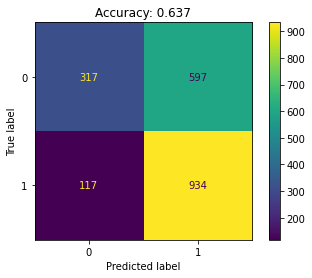

In [ ]:
test_lab = []
for i in list(n_t_d['Flames']):
  test_lab.append(int(i))
plot_cm(y=test_lab, pred=pred)

# Evaluate

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            # if self.aug:
            #     temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train

In [ ]:
def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      #print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      #print('num of frames is less than temporal length; hence discarding this \
      #      file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      #print('Exception: ', e)
      iterator = False
      #print('end of data generator ')
  return data_list

test_data = load_samples(CSV_folder='Test/urban/KFold_long-range/fold2', 
                            temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

52/52 [==============================] - 971s 19s/step


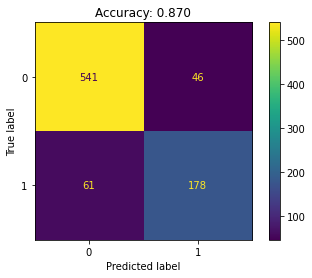

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = []
  for i in pred:
    p.append(round(list(i)[0]))
  p = np.array(p)
  y = np.array(y)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

model = load_model('models/urban/long-range/SqueezeNet/case12/case12_best_model2.h5')

test_labels = []
for test in range(len(test_data)):
  test_labels.append(test_data[test][1])

pred = model.predict(test_gen)
plot_cm(y=test_labels, pred=list(pred))

In [ ]:
model.evaluate(test_gen)

52/52 [==============================] - 118s 2s/step - loss: 0.3409 - accuracy: 0.8705


[0.34092050790786743, 0.870460033416748]

In [ ]:
p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)
y = np.array(test_labels)

test_labels = list(y)
scores = list(p)

In [ ]:
from keras.metrics import AUC # Approximates the Area Under the Curve of the ROC curve
from sklearn.metrics import balanced_accuracy_score

b_acc = balanced_accuracy_score(y_true=y, y_pred=p)

TP=TN=FP=FN = 0

for i in range(len(test_labels)):
    if test_labels[i] == 1 and scores[i] == 1:
        TP = TP + 1
    elif test_labels[i] == 0 and scores[i] == 0:
        TN = TN + 1
    elif test_labels[i] == 0 and scores[i] == 1:
        FP = FP + 1
    elif test_labels[i] == 1 and scores[i] == 0:
        FN = FN + 1

AR = (TP + TN)/(TP + TN + FP + FN)
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
TPR = TP/(TP + FN)
TNR = TN/(TN + FP)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
F1score = (2 * Precision * Recall)/(Precision + Recall)
Auc = AUC()
Auc.update_state(test_labels, scores)

print("True Positives: " + str(TP) + "\nTrue Negatives: " + str(TN) + 
      "\nFalse Positives: " + str(FP) + "\nFalse Negatives: " + str(FN) +
      "\nTrue Positive rate: " + str(round(TPR, 3)) + "\nTrue negative rate: " +
      str(round(TNR, 3)) + "\nFalse Positive rate: " + str(round(FPR, 3)) +
      "\nFalse Negative rate: " + str(round(FNR, 3)) + "\nAccuracy Rate: " + 
      str(round(AR, 3)) + "\nPrecision: " + str(round(Precision, 3)) + 
      "\nRecall: " + str(round(Recall, 3)) + "\nBalanced accuracy: " + 
      str(round(b_acc, 3)) + "\nF1-Score: " + str(round(F1score, 3)) + 
      "\nArea under ROC curve: " + str(round(float(Auc.result()), 3)))

True Positives: 178
True Negatives: 541
False Positives: 46
False Negatives: 61
True Positive rate: 0.745
True negative rate: 0.922
False Positive rate: 0.078
False Negative rate: 0.255
Accuracy Rate: 0.87
Precision: 0.795
Recall: 0.745
Balanced accuracy: 0.833
F1-Score: 0.769
Area under ROC curve: 0.833


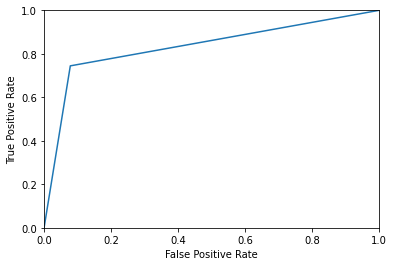

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=np.array(test_labels), y_score=p)
plot_roc_curve(fpr_keras,tpr_keras)

## Which samples are wrongly predicted?

In [ ]:
wrong_predictions01 = []
wrong_predictions10 = []

for i in range(len(test_labels)):
    if test_data[i][1] == 0 and scores[i] == 1:
      wrong_predictions01.append(test_data[i][0])
    if test_data[i][1] == 1 and scores[i] == 0:
      wrong_predictions10.append(test_data[i][0])

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions01[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions01:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong01 = pd.DataFrame(all_videos)
df_wrong01

,name,num
0,Car_Counting.mp4,23
1,depositphotos_390165084-stock-video-police-lig...,4
2,negsVideo16.1077.avi,9
3,istockphoto-1271222709-640_adpp_is.mp4,5
4,istockphoto-1436309016-640_adpp_is.mp4,5


In [ ]:
df_wrong01['num'].sum()

46

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions10[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions10:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong10 = pd.DataFrame(all_videos)
df_wrong10

,name,num
0,sBehindtheFence.avi,14
1,istockphoto-1328393940-640_adpp_is.mp4,9
2,istockphoto-1434212346-640_adpp_is.mp4,8
3,outdoor_night_20m_heptane_CCD_001.avi,8
4,petrochemical-plant-torch-1163768-PREVIEW.mp4,3
5,pexels-tima-miroshnichenko-5988901.mp4,6
6,production ID_4052131.mp4,4
7,production ID_4961452.mp4,9


In [ ]:
df_wrong10['num'].sum()

61

In [ ]:
wrong_predictions01

[['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/1.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/2.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/3.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/4.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/3.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/4.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/5.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/negative/Car_Counting.mp4/6.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/fram

In [ ]:
wrong_predictions10

[['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/85.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/86.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/87.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/88.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/87.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/88.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/89.jpg',
  '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/90.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/urban